In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = '/home/sdybing/gnss-picker/cnn_models_outputs/newfault_fq_train/models/traindate_2024-10-01/data/'

In [5]:
# data = np.load(path + '2024-10-15_gfast_fqtest_orig_data.npy')
# metadata = np.load(path + 'pgd_test_metadata_with_hypdists.npy')

data = np.load(path + '2024-10-19gfast_realtest_orig_data.npy')
metadata = np.load(path + 'pgd_realdata_test_metadata_w_hypdist_pgd_snrs.npy')

# np.save(data_save_dir + str(fqtestdate) + '_gfast_fqtest_target.npy', fqtest_target)
# np.save(data_save_dir + str(fqtestdate) + '_gfast_fqtest_predictions.npy', fqtest_predictions)

# New metadata array columns:

# 0. event ID
# 1: station name
# 2: date sample came from
# 3: sample start time
# 4: sample end time
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude
# 7. earthquake lat
# 8. earthquake lon
# 9. earthquake depth
# 10. station lat
# 11. station lon
# 12. hypocentral distance (m)
# 13. PGD (m)
# 14. SNRN
# 15. SNRE
# 16. SNRZ
# 17. mean SNR

In [6]:
all_true_mws = metadata[:,6].astype(float)

In [7]:
all_true_mws

array([4.3 , 4.85, 4.85, ..., 4.74, 5.  , 5.51])

In [8]:
# Crowell 2016 used PGD in cm, Rhyp in km 
# log10(PGD) = A + B*Mw + C*Mw*log10(Rhyp)
A = -6.687
B = 1.5
C = -0.214

pgd_ts_array = np.zeros((len(data), 128))
Mw_ts_array = np.zeros((len(data), 128))

for idx in range(len(data)):
    
    n = data[idx, :, 0]*100 # converting disp from m to cm
    e = data[idx, :, 1]*100
    z = data[idx, :, 2]*100
    
    Rhyp = float(metadata[idx,12])/1000
    actual_Mw = float(metadata[idx,6])
#     print(Rhyp)
    
#     plt.plot(n)
#     plt.plot(e)
#     plt.plot(z)
    
    pgd_ts = np.sqrt(n**2 + e**2 + z**2)
#     plt.plot(pgd_ts)
#     plt.show()
    
    Mw_ts = (np.log10(pgd_ts) - A) / (B + C * np.log10(Rhyp))
    
#     plt.plot(Mw_ts)
#     plt.show()
    
    pgd_ts_array[idx] = pgd_ts
    Mw_ts_array[idx] = Mw_ts
    
#     print(actual_Mw, np.max(Mw_ts))

In [9]:
all_calc_mws = []

for k in range(len(Mw_ts_array)):
    
    calc_Mw = np.max(Mw_ts_array[k])
    all_calc_mws.append(calc_Mw)
    
all_calc_mws = np.array(all_calc_mws)

In [10]:
all_calc_mws

array([6.55272768, 7.32300544, 7.31518174, ..., 7.13770103, 7.61223054,
       6.93598629])

In [11]:
# Get residuals

all_resids = []

for i in range(len(all_true_mws)):
    
    true_mw = all_true_mws[i]
    calc_mw = all_calc_mws[i]
    
    resid = true_mw - calc_mw
    all_resids.append(resid)
    
all_resids = np.array(all_resids)

In [12]:
all_resids

array([-2.25272768, -2.47300544, -2.46518174, ..., -2.39770103,
       -2.61223054, -1.42598629])

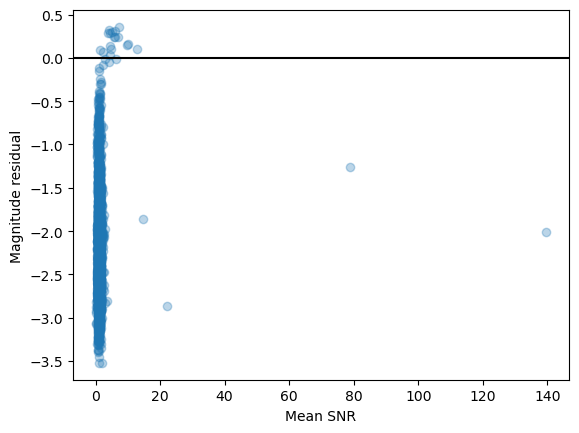

In [14]:
mean_SNRs = metadata[:,17].astype(float)

plt.scatter(mean_SNRs, all_resids, alpha = 0.3)
plt.axhline(y = 0, color = 'black')
plt.xlabel('Mean SNR')
plt.ylabel('Magnitude residual')

plt.show();

## Filter by SNR

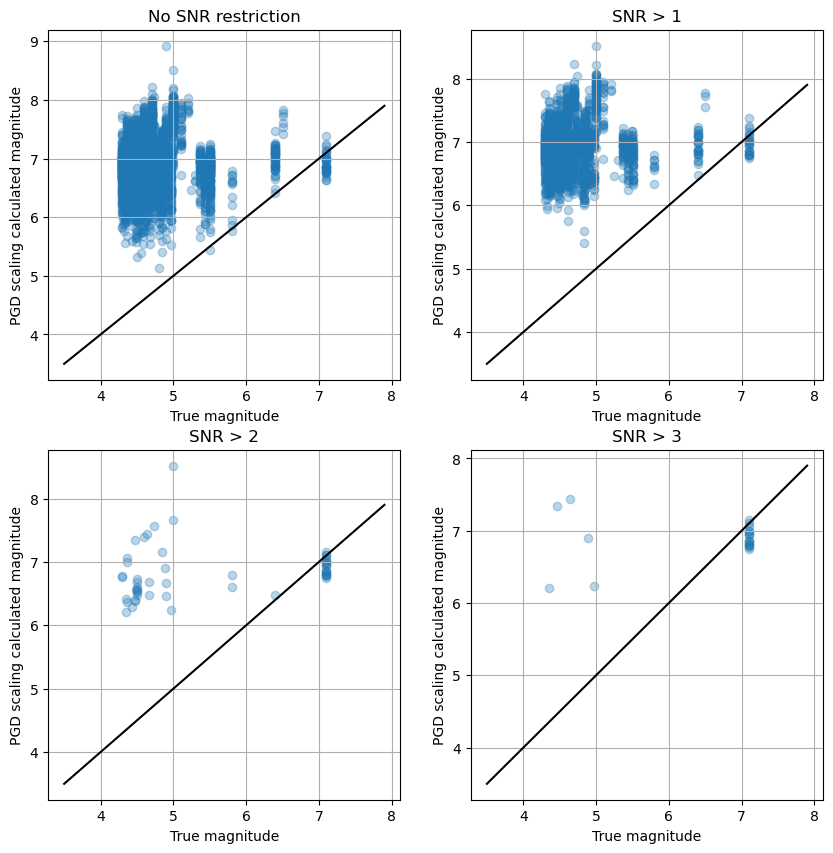

In [15]:
# Restricting plot by SNR

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
all_true_mws = metadata[:,6].astype(float)
plt.grid()
plt.scatter(all_true_mws, all_calc_mws, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('No SNR restriction')

plt.subplot(222)
k = np.where(mean_SNRs > 1)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 1')

plt.subplot(223)
k = np.where(mean_SNRs > 2)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 2')

plt.subplot(224)
k = np.where(mean_SNRs > 3)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 3')

plt.show();

### SNR filter event-average PGD magnitude

In [16]:
uni_rupts = np.unique(metadata[:,0])
print(uni_rupts)

['37219156' '37219164' '37219172' '37219180' '37219484' '37219500'
 '37219564' '37224964' '37421229' '37445989' '38443183' '38443191'
 '38443535' '38443607' '38443647' '38443719' '38443871' '38445087'
 '38450263' '38457487' '38457511' '38457519' '38457591' '38457615'
 '38457687' '38457703' '38457775' '38457815' '38457847' '38457967'
 '38458071' '38458079' '38458679' '38460311' '38460967' '38460975'
 '38460983' '38463551' '38469375' '38472279' '38488354' '38525207'
 '38525215' '38527863' '38548295' '38583335' '38585023' '38593535'
 '38624424' '38644943' '39106919' '39111991' '39133016' '39134160'
 '39201199' '39201215' '39201231' '39201263' '39201279' '39201407'
 '39201559' '39204599' '39205151' '39205383' '39207503' '39208087'
 '39223791' '39233472' '39273567' '39281127' '39289104' '39382424'
 '39382736' '39462536' '39485504' '39486360' '39493944' '39494008']


In [32]:
true_mws = []
calc_mws_none = []
calc_mws_1 = []
calc_mws_2 = []
calc_mws_3 = []

for idx2 in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx2]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_none = []
    mws_1 = []
    mws_2 = []
    mws_3 = []
    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_none.append(computed_mw)
        SNR = float(metadata[index,17])
#         print('SNR: ' + str(SNR))
        if SNR > 1:
#             print(computed_mw)
            mws_1.append(computed_mw)
        if SNR > 2:
#             print(computed_mw)
            mws_2.append(computed_mw)
        if SNR > 3:
#             print(computed_mw)
            mws_3.append(computed_mw)
    
#     print(mws_3)
    
    try:
        evt_avg_mean_Mw_none = np.mean(np.array(mws_none))
    except: 
        evt_avg_mean_Mw_none = np.nan
    try:
        evt_avg_mean_Mw_1 = np.mean(np.array(mws_1))
    except: 
        evt_avg_mean_Mw_1 = np.nan
    try:
        evt_avg_mean_Mw_2 = np.mean(np.array(mws_2))
    except: 
        evt_avg_mean_Mw_2 = np.nan
    try:
        evt_avg_mean_Mw_3 = np.mean(np.array(mws_3))
    except: 
        evt_avg_mean_Mw_3 = np.nan
    
    true_Mw = float(metadata[i,6][0])
#     print(metadata[i,2][0])

    true_mws.append(true_Mw)
    calc_mws_none.append(evt_avg_mean_Mw_none)
    calc_mws_1.append(evt_avg_mean_Mw_1)
    calc_mws_2.append(evt_avg_mean_Mw_2)
    calc_mws_3.append(evt_avg_mean_Mw_3)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


In [33]:
len(true_mws)

78

In [34]:
len(calc_mws_none)

78

In [35]:
print(true_mws)

[4.84, 4.61, 4.5, 4.5, 4.84, 4.84, 4.5, 4.85, 4.31, 5.3, 6.4, 4.49, 4.66, 4.59, 4.34, 4.58, 4.5, 4.43, 5.37, 4.97, 7.1, 4.84, 4.49, 4.35, 5.5, 4.97, 4.68, 4.8, 5.44, 4.85, 4.47, 4.47, 4.63, 4.56, 4.89, 4.49, 4.49, 4.5, 4.5, 4.53, 4.54, 4.52, 4.37, 4.3, 4.9, 4.47, 4.37, 4.64, 4.3, 4.74, 5.2, 4.32, 4.5, 4.8, 6.5, 4.9, 5.1, 4.8, 4.5, 4.3, 4.8, 4.5, 4.7, 4.3, 4.6, 5.0, 4.36, 4.3, 4.47, 4.5, 4.36, 5.24, 4.57, 5.51, 4.3, 5.0, 5.8, 4.59]


In [36]:
print(calc_mws_1)

[6.385676412165447, 6.319112715553396, 6.439307297433678, nan, 6.344042653618136, 6.326432214966449, nan, 7.062245908333174, 6.328639699310744, 6.718888421787995, 6.8398927749743565, 6.479746688816565, 6.718583502729037, 7.170369719617976, 6.992970101256471, 6.886175064721561, 6.638723580905471, 6.8682055250055445, 6.92130019938916, 6.927123274084711, 6.9773328432870025, 6.2505079243105, 6.505131931090742, 6.649126494060555, 6.952759847675565, 6.3750803527290545, 6.6330332712133595, 6.338527909036787, 6.773000736019853, 6.862541030811533, 6.572851787146669, 6.676824979776481, 6.818829769542733, 6.784553276658634, 6.940842458259644, 6.796042650283823, 6.902467970838949, 6.87869352710934, 6.739952462296354, 6.885817313969619, 6.6469200291596335, 6.819871017601303, 6.797907263705987, 6.795852028178221, 6.565746808092036, 7.233382508979651, 6.723971527002838, 6.698407781872835, 6.906551849684175, 6.9709512385730275, 7.849692525090531, 6.384666284457323, 7.550817251549353, nan, 7.6823933648

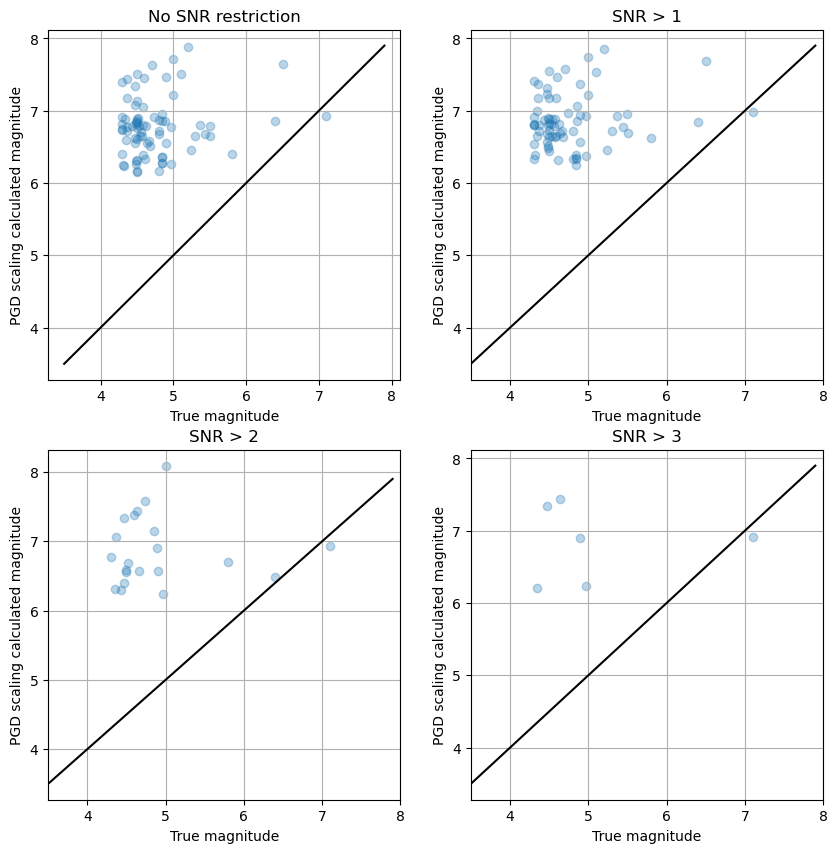

In [37]:
# Restricting event-average plot by SNR

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
plt.grid()
plt.scatter(true_mws, calc_mws_none, alpha = 0.3)
plt.plot(x, x, color = 'black')
# plt.xlim(3.5,8)
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('No SNR restriction')

plt.subplot(222)
plt.grid()
plt.scatter(true_mws, calc_mws_1, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlim(3.5,8)
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 1')

plt.subplot(223)
plt.grid()
plt.scatter(true_mws, calc_mws_2, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlim(3.5,8)
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 2')

plt.subplot(224)
plt.grid()
plt.scatter(true_mws, calc_mws_3, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlim(3.5,8)
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 3')

plt.show();

## Hypocentral distance filter



In [38]:
true_mws = []
calc_mws_all = []
calc_mws_25 = []
calc_mws_50 = []
calc_mws_100 = []
calc_mws_200 = []

for idx in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_all = []
    mws_25 = []
    mws_50 = []
    mws_100 = []
    mws_200 = []

    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_all.append(computed_mw)
        
        hypdist = float(metadata[index,12])/1000 # km
        if hypdist <= 25:
            mws_25.append(computed_mw)
        if hypdist <= 50:
            mws_50.append(computed_mw)
        if hypdist <= 100:
            mws_100.append(computed_mw)
        if hypdist <= 200:
            mws_200.append(computed_mw)
    
    try:
        evt_avg_mean_Mw_all = np.mean(np.array(mws_all))
    except: 
        evt_avg_mean_Mw_all = np.nan
    try:
        evt_avg_mean_Mw_25 = np.mean(np.array(mws_25))
    except: 
        evt_avg_mean_Mw_25 = np.nan
    try:
        evt_avg_mean_Mw_50 = np.mean(np.array(mws_50))
    except: 
        evt_avg_mean_Mw_50 = np.nan
    try:
        evt_avg_mean_Mw_100 = np.mean(np.array(mws_100))
    except: 
        evt_avg_mean_Mw_100 = np.nan
    try:
        evt_avg_mean_Mw_200 = np.mean(np.array(mws_200))
    except: 
        evt_avg_mean_Mw_200 = np.nan
    
    true_Mw = float(metadata[i,6][0])
    
    true_mws.append(true_Mw)
    calc_mws_all.append(evt_avg_mean_Mw_all)
    calc_mws_25.append(evt_avg_mean_Mw_25)
    calc_mws_50.append(evt_avg_mean_Mw_50)
    calc_mws_100.append(evt_avg_mean_Mw_100)
    calc_mws_200.append(evt_avg_mean_Mw_200)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


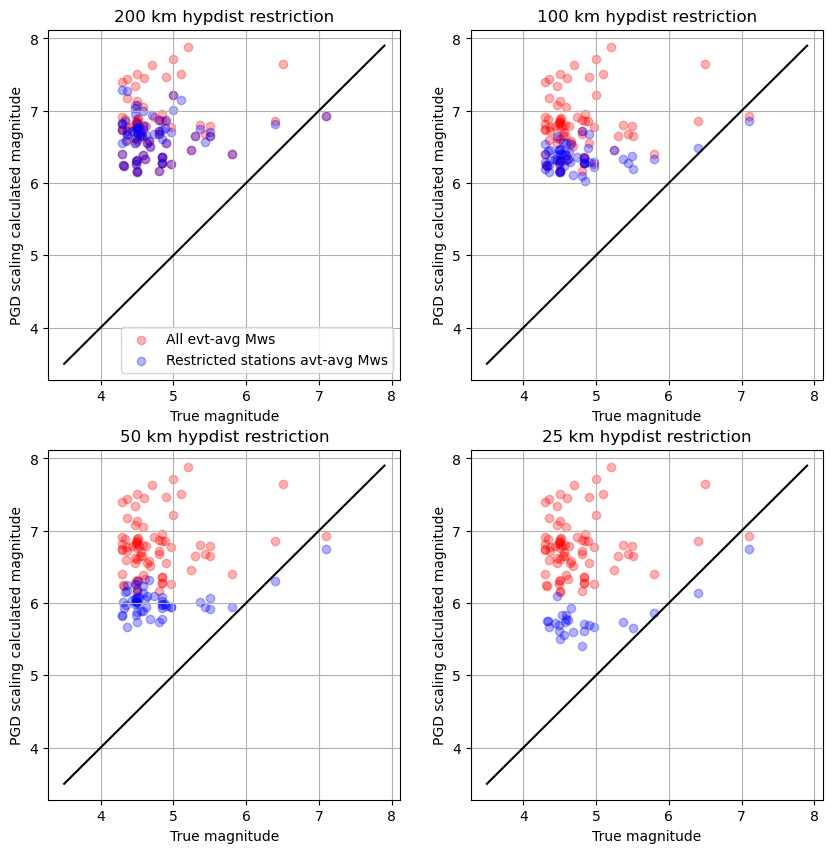

In [39]:
# Restricting event-average plot by hypdist

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3, label = 'All evt-avg Mws')
plt.scatter(true_mws, calc_mws_200, color = 'blue', alpha = 0.3, label = 'Restricted stations avt-avg Mws')
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('200 km hypdist restriction')
plt.legend()

plt.subplot(222)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_100, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('100 km hypdist restriction')

plt.subplot(223)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_50, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('50 km hypdist restriction')

plt.subplot(224)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_25, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('25 km hypdist restriction')

plt.show();

## Hypocentral distance weighting + 4 stations min to contribute (GFAST proxy)

In [40]:
true_mws = []
calc_mws_all = []
calc_mws_weighted = []

for idx in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    true_Mw = float(metadata[i,6][0])
    true_mws.append(true_Mw)
#     print('True: ' + str(round(true_Mw,2)))
    
    hypdists = metadata[i,12].astype(float)/1000
    computed_mws = np.max(Mw_ts_array[i], axis = 1)
    
#     print(hypdists.shape)
#     print(computed_mws.shape)
#     print(min(hypdists))
    
    evt_avg_mean_Mw_all = np.mean(computed_mws)
    calc_mws_all.append(evt_avg_mean_Mw_all)
#     print('Basic mean: ' + str(round(evt_avg_mean_Mw_all,2)))
    
    if len(computed_mws) < 4:
        weighted_evt_avg_Mw = np.nan
        calc_mws_weighted.append(weighted_evt_avg_Mw)
        continue
    
    weights = np.exp(-(hypdists**2) / (8 * (min(hypdists)**2)))
#     print(weights.shape)
    
    weighted_evt_avg_Mw = np.average(computed_mws, weights = weights)
    calc_mws_weighted.append(weighted_evt_avg_Mw)
#     print('Weighted mean: ' + str(round(weighted_evt_avg_Mw,2)))

print(len(true_mws))
print(len(calc_mws_all))
print(len(calc_mws_weighted))

78
78
78


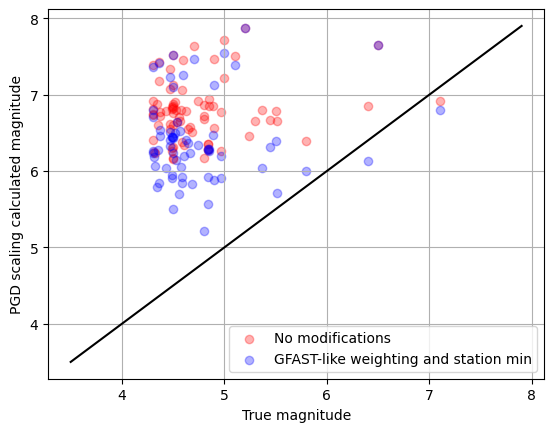

In [41]:
x = np.arange(3.5,8,0.1)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3, label = 'No modifications')
plt.scatter(true_mws, calc_mws_weighted, color = 'blue', alpha = 0.3, label = 'GFAST-like weighting and station min')
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.legend()

plt.show();

In [47]:
# Only works after running code 7
all_calc_mws = []

for k in range(len(Mw_ts_array)):
    
    calc_Mw = np.max(Mw_ts_array[k])
    all_calc_mws.append(calc_Mw)
    
results0135 = np.load(path + 'pgd_realdata_test_metadata_w_hypdist_pgd_snrs_result0135.npy') # Best accuracy threshold from FQ testing data
results0835 = np.load(path + 'pgd_realdata_test_metadata_w_hypdist_pgd_snrs_result0835.npy') # Best precision threshold from FQ testing data
results0135.shape

(3351, 19)

In [48]:
results0135[0]

array(['38624424', 'ACSB', '20190605', '2019-06-05T14:32:10.000000Z',
       '2019-06-05T14:34:17.000000Z', '18', '4.30', '32.8377',
       '-118.5032', '8.4', '33.27425', '-117.4449', '110059.31617383259',
       '0.019017414482512884', '1.2280982013876431', '1.2856022057334355',
       '0.991962893340317', '1.1685544334871318', 'false neg'],
      dtype='<U32')

In [44]:
# p = np.where(results[:,15] == 'false neg')[0]
# print(len(p))
# q = np.where(results[:,15] == 'true pos')[0]
# print(len(q))

# all_true_mws = metadata[:,2].astype(float)
# all_calc_mws = np.array(all_calc_mws)

# fn_all_true_mws = all_true_mws[p]
# fn_all_calc_mws = all_calc_mws[p]
# tp_all_true_mws = all_true_mws[q]
# tp_all_calc_mws = all_calc_mws[q]

# x = np.arange(3.5,8,0.1)
# plt.grid()
# plt.scatter(fn_all_true_mws, fn_all_calc_mws, color = 'red', alpha = 0.3, label = 'False negatives')
# plt.scatter(tp_all_true_mws, tp_all_calc_mws, color = 'blue', alpha = 0.3, label = 'True positives')
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.legend()

# plt.show();

In [45]:
# mean_SNRs = results[:,14].astype(float)

# fn_mean_SNRs = mean_SNRs[p]
# tp_mean_SNRs = mean_SNRs[q]
# fn_all_resids = np.array(all_resids)[p]
# tp_all_resids = np.array(all_resids)[q]

# plt.scatter(fn_mean_SNRs, fn_all_resids, color = 'red', alpha = 0.3, label = 'False negatives')
# plt.scatter(tp_mean_SNRs, tp_all_resids, color = 'blue', alpha = 0.3, label = 'True positives')
# plt.axhline(y = 0, color = 'black')
# plt.xlabel('Mean SNR')
# plt.ylabel('Magnitude residual')
# plt.legend()

# plt.show();

In [64]:
uni_rupts

array(['37219156', '37219164', '37219172', '37219180', '37219484',
       '37219500', '37219564', '37224964', '37421229', '37445989',
       '38443183', '38443191', '38443535', '38443607', '38443647',
       '38443719', '38443871', '38445087', '38450263', '38457487',
       '38457511', '38457519', '38457591', '38457615', '38457687',
       '38457703', '38457775', '38457815', '38457847', '38457967',
       '38458071', '38458079', '38458679', '38460311', '38460967',
       '38460975', '38460983', '38463551', '38469375', '38472279',
       '38488354', '38525207', '38525215', '38527863', '38548295',
       '38583335', '38585023', '38593535', '38624424', '38644943',
       '39106919', '39111991', '39133016', '39134160', '39201199',
       '39201215', '39201231', '39201263', '39201279', '39201407',
       '39201559', '39204599', '39205151', '39205383', '39207503',
       '39208087', '39223791', '39233472', '39273567', '39281127',
       '39289104', '39382424', '39382736', '39462536', '394855

In [66]:
event_catalog = np.genfromtxt('/home/sdybing/gnss-picker/data/realdata/minM4.3_event_catalog.txt', dtype = 'str')
c = np.where(event_catalog[:,5].astype(float) > 6)[0]
print(c)

[  2   4   7  11  12  14  15  17  21  22  29  35  42  43  44  47  50  52
  58  61  81  83  86  87  91  93  95  96 100 104 105 107 109 111 112 114
 124 125 126 128 134 135 137 141 144 145 148 149 156 160 161 166 175 179
 188 189 190 191 193 194 197 199 201 205 206 207 208 210 211 214 216 217
 223 224 228 229 230 234 242 243 245 258 259 261 262 264 273 274 275 276
 284 319 330 331 334 335 337 338 339 341 342 348 349 350 352 354 355 356
 357 360]


In [73]:
rupts_over_6 = []

for idx3 in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx3]
    c = np.where(event_catalog[:,0] == rupt)[0][0]
    mag = float(event_catalog[c,5])
    if mag > 6:
        print(rupt)
        print(event_catalog[c])
        rupts_over_6.append(event_catalog[c,0])
        
print(rupts_over_6)

38443183
['38443183' '2019-07-04T17:33:49.000000Z' '-117.5038' '35.7053' '10.50'
 '6.40']
38457511
['38457511' '2019-07-06T03:19:53.040000Z' '-117.5993' '35.7695' '8.00'
 '7.10']
39201199
['39201199' '2020-05-15T11:03:27.350000Z' '-117.8750' '38.1590' '2.74'
 '6.50']
['38443183', '38457511', '39201199']


38443183 6.4
66
65


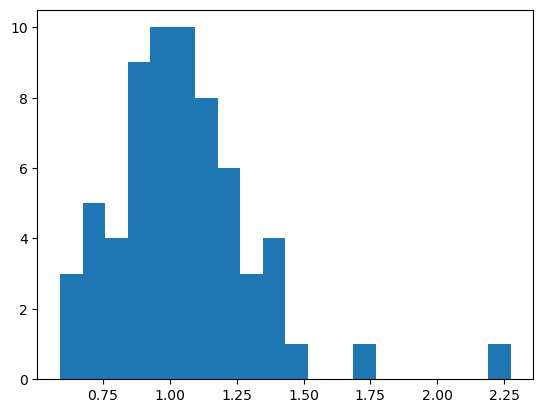

2
[2.27555941 1.70667913]
Min SNR: 0.5892164481298966
Max SNR: 2.275559413323648
Number of tps for 0.135: 16
Number of tps for 0.835: 0
Max hypdist for fn 0.135: 208.7162846300306
Max hypdist for fn 0.835: 208.7162846300306
Min hypdist for fn 0.135: 9.17783341410705
Min hypdist for fn 0.835: 9.17783341410705
38457511 7.1
31
23


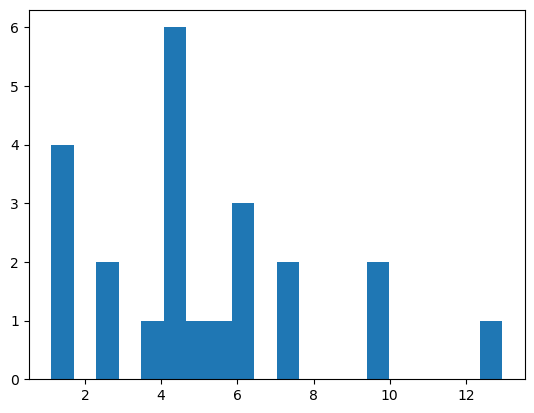

20
[ 5.89545636  7.2905985   4.10194733  4.39403229  4.39173238  4.23739698
  4.62642448  1.60770467  2.79945438  9.76152529  3.87042719  5.05788689
  9.9079645   5.62462244 12.94913146  6.25042355  7.05930633  6.14321407
  2.3700897   4.51916533]
Min SNR: 1.1118973896789366
Max SNR: 12.949131462558412
Number of tps for 0.135: 30
Number of tps for 0.835: 14
Max hypdist for fn 0.135: 23.571281839845305
Max hypdist for fn 0.835: 142.99711132122565
Min hypdist for fn 0.135: 23.571281839845305
Min hypdist for fn 0.835: 19.483499634077067
39201199 6.5
6
6


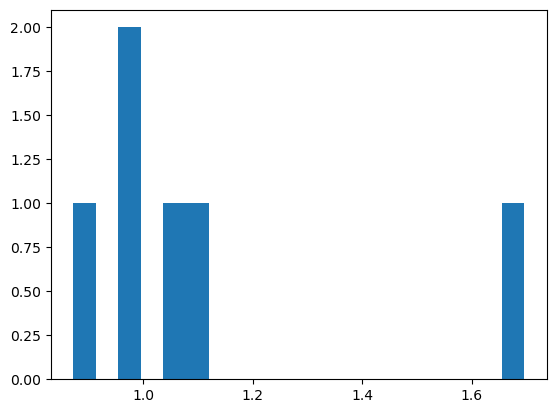

1
[1.69605274]
Min SNR: 0.8717307293874553
Max SNR: 1.6960527410875954
Number of tps for 0.135: 0
Number of tps for 0.835: 0
Max hypdist for fn 0.135: 445.767873199615
Max hypdist for fn 0.835: 445.767873199615
Min hypdist for fn 0.135: 400.0959937582206
Min hypdist for fn 0.835: 400.0959937582206


In [99]:
true_mws_0135 = []
calc_mws_fn_0135 = []
calc_mws_tp_0135 = []
true_mws_0835 = []
calc_mws_fn_0835 = []
calc_mws_tp_0835 = []

for idx2 in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx2]
#     print(rupt)
    
    i = np.where(results0135[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_tp_0135 = []
    mws_fn_0135 = []
    mws_tp_0835 = []
    mws_fn_0835 = []
    hd_tp_0135 = []
    hd_fn_0135 = []
    hd_tp_0835 = []
    hd_fn_0835 = []
    hypdists = []
    stas = []
    pgds = []
    snrs = []
    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_none.append(computed_mw)
        result_0135 = results0135[index,18]
        result_0835 = results0835[index,18]
        hypdist = float(results0135[index,12])/1000
        sta = results0135[index,1]
        pgd = float(results0135[index,13])*100
        snr = results0135[index,17]
        hypdists.append(hypdist)
        stas.append(sta)
        pgds.append(pgd)
        snrs.append(snr)
#         print('Result: ' + result)
        if result_0135 == 'true pos':
            mws_tp_0135.append(computed_mw)
            hd_tp_0135.append(hypdist)
        elif result_0135 == 'false neg':
            mws_fn_0135.append(computed_mw)
            hd_fn_0135.append(hypdist)
        if result_0835 == 'true pos':
            mws_tp_0835.append(computed_mw)
            hd_tp_0835.append(hypdist)
        elif result_0835 == 'false neg':
            mws_fn_0835.append(computed_mw)
            hd_fn_0835.append(hypdist)
    
    try:
        evt_avg_mean_Mw_tp_0135 = np.mean(np.array(mws_tp_0135))
    except:
        evt_avg_mean_Mw_tp_0135 = np.nan
    try:
        evt_avg_mean_Mw_fn_0135 = np.mean(np.array(mws_fn_0135))
    except:
        evt_avg_mean_Mw_fn_0135 = np.nan
    try:
        evt_avg_mean_Mw_tp_0835 = np.mean(np.array(mws_tp_0835))
    except:
        evt_avg_mean_Mw_tp_0835 = np.nan
    try:
        evt_avg_mean_Mw_fn_0835 = np.mean(np.array(mws_fn_0835))
    except:
        evt_avg_mean_Mw_fn_0835 = np.nan
    
    true_Mw = float(metadata[i,6][0])
    
    if rupt in rupts_over_6:
        try:
            print(rupt, true_Mw)
            print(len(hypdists))
            edit_snrs = []
            for d in range(len(stas)):
                sta = stas[d]
                hypdist = hypdists[d]
                pgd = pgds[d]
                snr = snrs[d]
                if snr != 'nan':
                    edit_snrs.append(float(snr))
#                 print(sta, hypdist, pgd, snr)
            print(len(edit_snrs))
            plt.hist(edit_snrs, bins = 20)
            plt.show()
            h = np.where(np.array(edit_snrs) > 1.5)[0]
            print(len(h))
            print(np.array(edit_snrs)[h])
            print('Min SNR: ' + str(np.min(np.array(edit_snrs))))
            print('Max SNR: ' + str(np.max(np.array(edit_snrs))))
            print('Number of tps for 0.135: ' + str(len(mws_tp_0135)))
            print('Number of tps for 0.835: ' + str(len(mws_tp_0835)))
#             print('Max hypdist for tp 0.135: ' + str(np.max(np.array(hd_tp_0135))))
            print('Max hypdist for fn 0.135: ' + str(np.max(np.array(hd_fn_0135))))
#             print('Max hypdist for tp 0.835: ' + str(np.max(np.array(hd_tp_0835))))
            print('Max hypdist for fn 0.835: ' + str(np.max(np.array(hd_fn_0835))))
    #             print('Max hypdist for tp 0.135: ' + str(np.max(np.array(hd_tp_0135))))
            print('Min hypdist for fn 0.135: ' + str(np.min(np.array(hd_fn_0135))))
#             print('Max hypdist for tp 0.835: ' + str(np.max(np.array(hd_tp_0835))))
            print('Min hypdist for fn 0.835: ' + str(np.min(np.array(hd_fn_0835))))
        except:
            pass
#         print(hypdists)
    
    true_mws_0135.append(true_Mw)
    true_mws_0835.append(true_Mw)
    calc_mws_fn_0135.append(evt_avg_mean_Mw_fn_0135)
    calc_mws_tp_0135.append(evt_avg_mean_Mw_tp_0135)
    calc_mws_fn_0835.append(evt_avg_mean_Mw_fn_0835)
    calc_mws_tp_0835.append(evt_avg_mean_Mw_tp_0835)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


In [51]:
len(calc_mws_tp_0135)

78

In [52]:
len(calc_mws_tp_0835)

78

In [74]:
# # Restricting event-average plot by TPs

# plt.figure(figsize = (10,5), dpi = 100)

# x = np.arange(3.5,8,0.1)

# plt.subplot(121)
# plt.grid()
# plt.scatter(true_mws, calc_mws_fn, color = 'red', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.title('False negatives')

# plt.subplot(122)
# plt.grid()
# plt.scatter(true_mws, calc_mws_tp, color = 'blue', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.title('True positives')

# plt.show();

In [75]:
# # Restricting event-average plot by SNR

# plt.figure(figsize = (6,5), dpi = 100)

# x = np.arange(3.5,8,0.1)

# plt.grid()
# plt.scatter(true_mws, calc_mws_fn, color = 'red', alpha = 0.3)
# plt.scatter(true_mws, calc_mws_tp, color = 'blue', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')

# plt.show();

## Combining plots


In [53]:
true_event_mags = np.array(true_mws)
print(true_event_mags.shape)

calc_event_mags_nofilter = np.array(calc_mws_all)
print(calc_event_mags_nofilter.shape)

calc_event_mags_snr1 = np.array(calc_mws_1)
calc_event_mags_snr2 = np.array(calc_mws_2)
calc_event_mags_snr3 = np.array(calc_mws_3)

calc_event_mags_tps_0135 = np.array(calc_mws_tp_0135)
print(calc_event_mags_tps_0135.shape)
calc_event_mags_tps_0835 = np.array(calc_mws_tp_0835)
print(calc_event_mags_tps_0835.shape)

calc_event_mags_gfastweight = np.array(calc_mws_weighted)

(78,)
(78,)
(78,)
(78,)


In [63]:
b = np.where(true_event_mags == 7.1)[0][0]
print(calc_event_mags_tps_0835[b])
print(calc_event_mags_nofilter[b])

6.969537648983136
6.921224316470137


In [55]:
# Calculating residuals and mean squared errors

all_residuals = true_event_mags - calc_event_mags_nofilter
snr1_residuals = true_event_mags - calc_event_mags_snr1
snr2_residuals = true_event_mags - calc_event_mags_snr2
snr3_residuals = true_event_mags - calc_event_mags_snr3
tp_0135_residuals = true_event_mags - calc_event_mags_tps_0135
tp_0835_residuals = true_event_mags - calc_event_mags_tps_0835
gfast_residuals = true_event_mags - calc_event_mags_gfastweight

# Remove nans from snr and tp ones to compute mse:

snr1_resids_nonan = []
for i in range(len(snr1_residuals)):
    resid = str(snr1_residuals[i])
    if resid != 'nan':
        snr1_resids_nonan.append(float(resid))
snr1_resids_nonan = np.array(snr1_resids_nonan)
# print(snr1_resids_nonan.shape)

snr2_resids_nonan = []
for i in range(len(snr2_residuals)):
    resid = str(snr2_residuals[i])
    if resid != 'nan':
        snr2_resids_nonan.append(float(resid))
snr2_resids_nonan = np.array(snr2_resids_nonan)
# print(snr2_resids_nonan.shape)

snr3_resids_nonan = []
for i in range(len(snr3_residuals)):
    resid = str(snr3_residuals[i])
    if resid != 'nan':
        snr3_resids_nonan.append(float(resid))
snr3_resids_nonan = np.array(snr3_resids_nonan)
# print(snr3_resids_nonan.shape)

tp_0135_resids_nonan = []
for i in range(len(tp_0135_residuals)):
    resid = str(tp_0135_residuals[i])
    if resid != 'nan':
        tp_0135_resids_nonan.append(float(resid))
tp_0135_resids_nonan = np.array(tp_0135_resids_nonan)
# print(tp_0135_resids_nonan.shape)

tp_0835_resids_nonan = []
for i in range(len(tp_0835_residuals)):
    resid = str(tp_0835_residuals[i])
    if resid != 'nan':
        tp_0835_resids_nonan.append(float(resid))
tp_0835_resids_nonan = np.array(tp_0835_resids_nonan)
# print(tp_0835_resids_nonan.shape)

gfast_resids_nonan = []
for i in range(len(gfast_residuals)):
    resid = str(gfast_residuals[i])
    if resid != 'nan':
        gfast_resids_nonan.append(float(resid))
gfast_resids_nonan = np.array(gfast_resids_nonan)
# print(gfast_resids_nonan.shape)

all_mse = round(np.mean(all_residuals**2),3)
snr1_mse = round(np.mean(snr1_resids_nonan**2),3)
snr2_mse = round(np.mean(snr2_resids_nonan**2),3)
snr3_mse = round(np.mean(snr3_resids_nonan**2),3)
tp_0135_mse = round(np.mean(tp_0135_resids_nonan**2),3)
tp_0835_mse = round(np.mean(tp_0835_resids_nonan**2),3)
gfast_mse = round(np.mean(gfast_resids_nonan**2),3)

print(all_mse)
print(snr1_mse)
print(snr2_mse)
print(snr3_mse)
print(tp_0135_mse)
print(tp_0835_mse)
print(gfast_mse)

4.467
4.715
4.639
4.207
4.316
0.017
3.246


In [60]:
# Event-averaged only

x = np.arange(3.5,8,0.1)

plt.figure(figsize = (10,13), dpi = 400)

plt.subplot(321)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(a)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_gfastweight, color = 'blue', alpha = 0.3, label = 'GFAST-like distance\nweighting and 4\nstation minimum')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'GFAST MSE: ' + str(gfast_mse) + '\nEvents qualified: ' + str(round(len(gfast_residuals)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude', fontsize = 12)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('GFAST-like distance weighting and 4 station min')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(322)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(b)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr1, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 1')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 1 MSE: ' + str(snr1_mse) + '\nEvents qualified: ' + str(round(len(snr1_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 2 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(323)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(c)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr2, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 2')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 2 MSE: ' + str(snr2_mse) + '\nEvents qualified: ' + str(round(len(snr2_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
plt.ylabel('PGD scaling calculated event-averaged magnitude', fontsize = 15, labelpad = 8)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 2 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(324)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(d)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr3, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 3')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 3 MSE: ' + str(snr3_mse) + '\nEvents qualified: ' + str(round(len(snr3_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel(x = 0.9, y = 0, xlabel = 'True magnitude', fontsize = 15, labelpad = 8)
# plt.ylabel(x = 0, y = 0.9, ylabel = 'PGD scaling calculated magnitude', fontsize = 15, labelpad = 8)
plt.ylabel('PGD scaling calculated event-averaged magnitude', fontsize = 15, labelpad = 8)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 3 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11, bottom = False, labelbottom = False)

plt.subplot(325)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(e)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_tps_0135, color = 'blue', alpha = 0.3, label = 'CNN threshold 0.135\ntrue positive stations')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'CNN TP thresh 0.135 MSE: ' + str(tp_0135_mse) + '\nEvents qualified: ' + str(round(len(tp_0135_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('CNN true positives only')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11)

plt.subplot(326)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(f)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_tps_0835, color = 'blue', alpha = 0.3, label = 'CNN threshold 0.835\ntrue positive stations')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'CNN TP thresh 0.835 MSE: ' + str(tp_0835_mse) + '\nEvents qualified: ' + str(round(len(tp_0835_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
plt.xlabel(x = -0.1, y = 0, xlabel = 'True magnitude', fontsize = 15, labelpad = 8)
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('CNN true positives only')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11)

plt.subplots_adjust(hspace = 0, wspace = 0.38)

# plt.show();

plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/realdata_gfast_test.jpg', format = 'JPG')
plt.close();